In [113]:
"""
https://www.kaggle.com/code/raghavkachroo/supreme-court-judgement-prediction/notebook
"""

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score
## for data
import pandas as pd

import re
import nltk## for language detection



import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [114]:
df = pd.read_csv('justice.csv', delimiter=',', encoding = "utf8")
print(len(df))

# NaN값 삭제
df.dropna(inplace=True)
print(len(df))

df.head()

3303
3098


,Unnamed: 0,ID,name,href,docket,term,first_party,second_party,facts,facts_len,majority_vote,minority_vote,first_party_winner,decision_type,disposition,issue_area
1,1,50613,Stanley v. Illinois,https://api.oyez.org/cases/1971/70-5014,70-5014,1971,"Peter Stanley, Sr.",Illinois,<p>Joan Stanley had three children with Peter ...,757,5,2,True,majority opinion,reversed/remanded,Civil Rights
2,2,50623,Giglio v. United States,https://api.oyez.org/cases/1971/70-29,70-29,1971,John Giglio,United States,<p>John Giglio was convicted of passing forged...,495,7,0,True,majority opinion,reversed/remanded,Due Process
3,3,50632,Reed v. Reed,https://api.oyez.org/cases/1971/70-4,70-4,1971,Sally Reed,Cecil Reed,"<p>The Idaho Probate Code specified that ""male...",378,7,0,True,majority opinion,reversed/remanded,Civil Rights
4,4,50643,Miller v. California,https://api.oyez.org/cases/1971/70-73,70-73,1971,Marvin Miller,California,"<p>Miller, after conducting a mass mailing cam...",305,5,4,True,majority opinion,vacated/remanded,First Amendment
5,5,50644,Kleindienst v. Mandel,https://api.oyez.org/cases/1971/71-16,71-16,1971,"Richard G. Kleindienst, Attorney General of th...","Ernest E. Mandel, et al.",<p>Ernest E. Mandel was a Belgian professional...,2282,6,3,True,majority opinion,reversed,First Amendment


In [115]:
df1 = df.copy()

In [116]:
df1.drop(columns=['Unnamed: 0', 'docket','name','first_party','second_party', 'issue_area', 
                 'facts_len', 'majority_vote', 'minority_vote', 'href', 'ID','term'], inplace=True)

In [117]:
df1.head()

,facts,first_party_winner,decision_type,disposition
1,<p>Joan Stanley had three children with Peter ...,True,majority opinion,reversed/remanded
2,<p>John Giglio was convicted of passing forged...,True,majority opinion,reversed/remanded
3,"<p>The Idaho Probate Code specified that ""male...",True,majority opinion,reversed/remanded
4,"<p>Miller, after conducting a mass mailing cam...",True,majority opinion,vacated/remanded
5,<p>Ernest E. Mandel was a Belgian professional...,True,majority opinion,reversed


In [118]:
df_cat = df1[['decision_type', 'disposition']]
df_target = df1['first_party_winner']
df_nlp = df1['facts']
print(df_target)

1        True
2        True
3        True
4        True
5        True
        ...  
3297     True
3298     True
3299    False
3300     True
3302     True
Name: first_party_winner, Length: 3098, dtype: object


In [119]:
# NaN값 삭제
df_cat.reset_index(drop=True, inplace=True)
df_target.reset_index(drop=True, inplace=True)
df_nlp.reset_index(drop=True, inplace=True)

In [120]:
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
print(df_target)

# True and False -> 1, 0
df_target= label_encoder.fit_transform(df_target)
print(len(df_target))
print(df_target)

0        True
1        True
2        True
3        True
4        True
        ...  
3093     True
3094     True
3095    False
3096     True
3097     True
Name: first_party_winner, Length: 3098, dtype: object
3098
[1 1 1 ... 0 1 1]


In [121]:
df_target1 = pd.DataFrame(df_target, columns=['first_party_winner'])
df_target1

,first_party_winner
0,1
1,1
2,1
3,1
4,1
...,...
3093,1
3094,1
3095,0
3096,1


In [122]:
frames = [df_cat, df_target1]
df_concat = pd.concat(frames, axis=1, join='inner')
df_concat

,decision_type,disposition,first_party_winner
0,majority opinion,reversed/remanded,1
1,majority opinion,reversed/remanded,1
2,majority opinion,reversed/remanded,1
3,majority opinion,vacated/remanded,1
4,majority opinion,reversed,1
...,...,...,...
3093,majority opinion,reversed/remanded,1
3094,majority opinion,reversed/remanded,1
3095,majority opinion,affirmed,0
3096,majority opinion,vacated/remanded,1


In [123]:
# 불필요한 기호들 제거
df_nlp1 = pd.DataFrame(df_nlp, columns=['facts'])
df_nlp1['facts'] = df_nlp1['facts'].str.replace(r'<[^<>]*>', '', regex=True)
df_nlp1

,facts
0,Joan Stanley had three children with Peter Sta...
1,John Giglio was convicted of passing forged mo...
2,"The Idaho Probate Code specified that ""males m..."
3,"Miller, after conducting a mass mailing campai..."
4,Ernest E. Mandel was a Belgian professional jo...
...,...
3093,For over a century after the Alaska Purchase i...
3094,"Refugio Palomar-Santiago, a Mexican national, ..."
3095,Tarahrick Terry pleaded guilty to one count of...
3096,Joshua James Cooley was parked in his pickup t...


In [124]:
# 토큰화
corpus = df_nlp1["facts"]
lst_tokens = nltk.tokenize.word_tokenize(corpus.str.cat(sep=" "))

print(len(lst_tokens))
lst_tokens

611566


['Joan',
 'Stanley',
 'had',
 'three',
 'children',
 'with',
 'Peter',
 'Stanley',
 '.',
 'The',
 'Stanleys',
 'never',
 'married',
 ',',
 'but',
 'lived',
 'together',
 'off',
 'and',
 'on',
 'for',
 '18',
 'years',
 '.',
 'When',
 'Joan',
 'died',
 ',',
 'the',
 'State',
 'of',
 'Illinois',
 'took',
 'the',
 'children',
 '.',
 'Under',
 'Illinois',
 'law',
 ',',
 'unwed',
 'fathers',
 'were',
 'presumed',
 'unfit',
 'parents',
 'regardless',
 'of',
 'their',
 'actual',
 'fitness',
 'and',
 'their',
 'children',
 'became',
 'wards',
 'of',
 'the',
 'state',
 '.',
 'Peter',
 'appealed',
 'the',
 'decision',
 ',',
 'arguing',
 'that',
 'the',
 'Illinois',
 'law',
 'violated',
 'the',
 'Equal',
 'Protection',
 'Clause',
 'of',
 'the',
 'Fourteenth',
 'Amendment',
 'because',
 'unwed',
 'mothers',
 'were',
 'not',
 'deprived',
 'of',
 'their',
 'children',
 'without',
 'a',
 'showing',
 'that',
 'they',
 'were',
 'actually',
 'unfit',
 'parents',
 '.',
 'The',
 'Illinois',
 'Supreme',
 'C

In [125]:
"""
Stemming(어간 추출): This -> thi

Lemmatization(표제어 추출, 기본형): lives -> life
""" 

ps = nltk.stem.porter.PorterStemmer()
lem = nltk.stem.wordnet.WordNetLemmatizer()

In [126]:
lst_stopwords = nltk.corpus.stopwords.words("english")

In [127]:
def utils_preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):
    ## clean (convert to lowercase and remove punctuations and characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
            
    ## Tokenize (convert from string to list)
    lst_text = text.split()    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
                
    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)
    return text

In [128]:
df_nlp1["facts_clean"] = df_nlp1["facts"].apply(lambda x: utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, lst_stopwords=lst_stopwords))

In [129]:
df_nlp1

,facts,facts_clean
0,Joan Stanley had three children with Peter Sta...,joan stanley three child peter stanley stanley...
1,John Giglio was convicted of passing forged mo...,john giglio convicted passing forged money ord...
2,"The Idaho Probate Code specified that ""males m...",idaho probate code specified male must preferr...
3,"Miller, after conducting a mass mailing campai...",miller conducting mass mailing campaign advert...
4,Ernest E. Mandel was a Belgian professional jo...,ernest e mandel belgian professional journalis...
...,...,...
3093,For over a century after the Alaska Purchase i...,century alaska purchase 1867 federal governmen...
3094,"Refugio Palomar-Santiago, a Mexican national, ...",refugio palomarsantiago mexican national grant...
3095,Tarahrick Terry pleaded guilty to one count of...,tarahrick terry pleaded guilty one count posse...
3096,Joshua James Cooley was parked in his pickup t...,joshua james cooley parked pickup truck side r...


In [130]:
df_nlp2 = pd.concat([df_nlp1,df_target1['first_party_winner']],axis=1, join='inner')

In [131]:
df_nlp2["first_party_winner"].value_counts()

1    2067
0    1031
Name: first_party_winner, dtype: int64

In [132]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

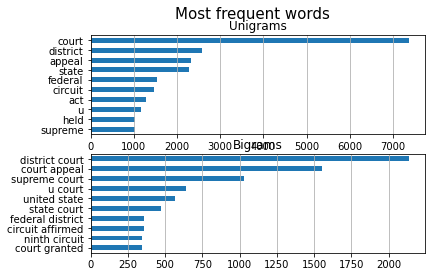

In [133]:
y = 1
corpus = df_nlp2[df_nlp2["first_party_winner"]== y]["facts_clean"]
lst_tokens = nltk.tokenize.word_tokenize(corpus.str.cat(sep=" "))
fig, ax = plt.subplots(nrows=2, ncols=1)
fig.suptitle("Most frequent words", fontsize=15)
#figure(figsize=(30, 24))
## unigrams
dic_words_freq = nltk.FreqDist(lst_tokens)
dtf_uni = pd.DataFrame(dic_words_freq.most_common(), 
                       columns=["Word","Freq"])
dtf_uni.set_index("Word").iloc[:10,:].sort_values(by="Freq").plot(
                  kind="barh", title="Unigrams", ax=ax[0], 
                  legend=False).grid(axis='x')
ax[0].set(ylabel=None)
    
## bigrams
dic_words_freq = nltk.FreqDist(nltk.ngrams(lst_tokens, 2))
dtf_bi = pd.DataFrame(dic_words_freq.most_common(), 
                      columns=["Word","Freq"])
dtf_bi["Word"] = dtf_bi["Word"].apply(lambda x: " ".join(
                   string for string in x) )
dtf_bi.set_index("Word").iloc[:10,:].sort_values(by="Freq").plot(
                  kind="barh", title="Bigrams", ax=ax[1],
                  legend=False).grid(axis='x')
ax[1].set(ylabel=None)
plt.show()

In [134]:
import wordcloud

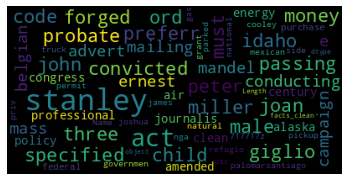

In [135]:
wc = wordcloud.WordCloud(background_color='black', max_words=100, 
                         max_font_size=35)
wc = wc.generate(str(corpus))
fig = plt.figure(num=1)
plt.axis('off')
plt.imshow(wc, cmap=None)
plt.show()

In [136]:
import gensim.downloader as gensim_api
import gensim
import seaborn as sns

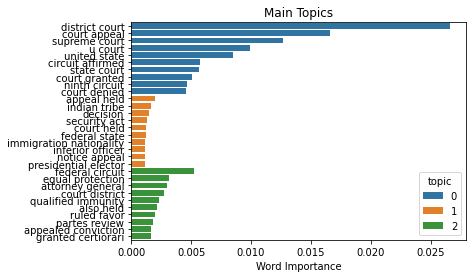

In [137]:
y = 1
corpus = df_nlp2[df_nlp2["first_party_winner"]==y]["facts_clean"]
## pre-process corpus
lst_corpus = []
for string in corpus:
    lst_words = string.split()
    lst_grams = [" ".join(lst_words[i:i + 2]) for i in range(0, 
                     len(lst_words), 2)]
    lst_corpus.append(lst_grams)## map words to an id
id2word = gensim.corpora.Dictionary(lst_corpus)## create dictionary word:freq
dic_corpus = [id2word.doc2bow(word) for word in lst_corpus] ## train LDA
lda_model = gensim.models.ldamodel.LdaModel(corpus=dic_corpus, id2word=id2word, num_topics=7, random_state=123, update_every=1, chunksize=100, passes=10, alpha='auto', per_word_topics=True)
   
## output
lst_dics = []
for i in range(0,3):
    lst_tuples = lda_model.get_topic_terms(i)
    for tupla in lst_tuples:
        lst_dics.append({"topic":i, "id":tupla[0], 
                         "word":id2word[tupla[0]], 
                         "weight":tupla[1]})
dtf_topics = pd.DataFrame(lst_dics, 
                         columns=['topic','id','word','weight'])

## plot
fig, ax = plt.subplots()
sns.barplot(y="word", x="weight", hue="topic", data=dtf_topics, dodge=False, ax=ax).set_title('Main Topics')
ax.set(ylabel="", xlabel="Word Importance")
plt.show()


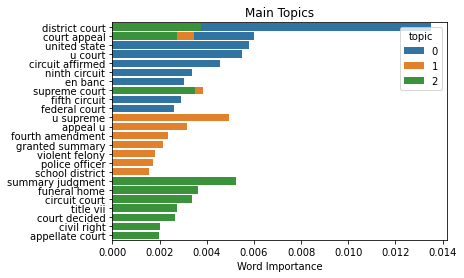

In [138]:
y = 0
corpus = df_nlp2[df_nlp2["first_party_winner"]==y]["facts_clean"]
## pre-process corpus
lst_corpus = []
for string in corpus:
    lst_words = string.split()
    lst_grams = [" ".join(lst_words[i:i + 2]) for i in range(0, 
                     len(lst_words), 2)]
    lst_corpus.append(lst_grams)## map words to an id
id2word = gensim.corpora.Dictionary(lst_corpus)## create dictionary word:freq
dic_corpus = [id2word.doc2bow(word) for word in lst_corpus] ## train LDA
lda_model = gensim.models.ldamodel.LdaModel(corpus=dic_corpus, id2word=id2word, num_topics=7, random_state=123, update_every=1, chunksize=100, passes=10, alpha='auto', per_word_topics=True)
   
## output
lst_dics = []
for i in range(0,3):
    lst_tuples = lda_model.get_topic_terms(i)
    for tupla in lst_tuples:
        lst_dics.append({"topic":i, "id":tupla[0], 
                         "word":id2word[tupla[0]], 
                         "weight":tupla[1]})
dtf_topics = pd.DataFrame(lst_dics, 
                         columns=['topic','id','word','weight'])

## plot
fig, ax = plt.subplots()
sns.barplot(y="word", x="weight", hue="topic", data=dtf_topics, dodge=False, ax=ax).set_title('Main Topics')
ax.set(ylabel="", xlabel="Word Importance")
plt.show()

In [139]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer

In [140]:
df_nlp1

,facts,facts_clean
0,Joan Stanley had three children with Peter Sta...,joan stanley three child peter stanley stanley...
1,John Giglio was convicted of passing forged mo...,john giglio convicted passing forged money ord...
2,"The Idaho Probate Code specified that ""males m...",idaho probate code specified male must preferr...
3,"Miller, after conducting a mass mailing campai...",miller conducting mass mailing campaign advert...
4,Ernest E. Mandel was a Belgian professional jo...,ernest e mandel belgian professional journalis...
...,...,...
3093,For over a century after the Alaska Purchase i...,century alaska purchase 1867 federal governmen...
3094,"Refugio Palomar-Santiago, a Mexican national, ...",refugio palomarsantiago mexican national grant...
3095,Tarahrick Terry pleaded guilty to one count of...,tarahrick terry pleaded guilty one count posse...
3096,Joshua James Cooley was parked in his pickup t...,joshua james cooley parked pickup truck side r...


In [141]:
df_target1['first_party_winner']

0       1
1       1
2       1
3       1
4       1
       ..
3093    1
3094    1
3095    0
3096    1
3097    1
Name: first_party_winner, Length: 3098, dtype: int64

In [143]:
df_nlp2

,facts,facts_clean,first_party_winner
0,Joan Stanley had three children with Peter Sta...,joan stanley three child peter stanley stanley...,1
1,John Giglio was convicted of passing forged mo...,john giglio convicted passing forged money ord...,1
2,"The Idaho Probate Code specified that ""males m...",idaho probate code specified male must preferr...,1
3,"Miller, after conducting a mass mailing campai...",miller conducting mass mailing campaign advert...,1
4,Ernest E. Mandel was a Belgian professional jo...,ernest e mandel belgian professional journalis...,1
...,...,...,...
3093,For over a century after the Alaska Purchase i...,century alaska purchase 1867 federal governmen...,1
3094,"Refugio Palomar-Santiago, a Mexican national, ...",refugio palomarsantiago mexican national grant...,1
3095,Tarahrick Terry pleaded guilty to one count of...,tarahrick terry pleaded guilty one count posse...,0
3096,Joshua James Cooley was parked in his pickup t...,joshua james cooley parked pickup truck side r...,1


In [142]:
vectorizer = CountVectorizer()

df_nlp2 = pd.concat([df_nlp1,df_target1['first_party_winner']],axis=1, join='inner')

xfeatures = df_nlp2['facts_clean']
ylabel = df_nlp2['first_party_winner']

In [73]:
X_train, X_test, y_train, y_test = train_test_split(xfeatures,ylabel, test_size=0.25)

In [75]:
pipe = Pipeline(steps=[('cv',CountVectorizer()),('lr',LogisticRegression(solver='liblinear'))])

In [76]:
pipe.fit(X_train,y_train)

Pipeline(steps=[('cv', CountVectorizer()),
                ('lr', LogisticRegression(solver='liblinear'))])

In [77]:
pipe.score(X_test,y_test)

0.6103225806451613

In [78]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

In [79]:
pipe1= Pipeline(steps=[('cv',CountVectorizer()),('rf',RandomForestClassifier())])
pipe1.fit(X_train,y_train)

Pipeline(steps=[('cv', CountVectorizer()), ('rf', RandomForestClassifier())])

In [80]:
pipe1.score(X_train,y_train)

1.0

In [81]:
pipe1.score(X_test,y_test)

0.6606451612903226

In [82]:
pipe2= Pipeline(steps=[('cv',CountVectorizer()),('rf',KNeighborsClassifier(n_neighbors=3))])

In [83]:
pipe2.fit(X_train,y_train)

Pipeline(steps=[('cv', CountVectorizer()),
                ('rf', KNeighborsClassifier(n_neighbors=3))])

In [84]:
pipe2.score(X_train,y_train)

0.8699956952216961

In [85]:
pipe2.score(X_test,y_test)

0.5870967741935483

In [86]:
df_nlp2

,facts,facts_clean,first_party_winner
0,Joan Stanley had three children with Peter Sta...,joan stanley three child peter stanley stanley...,1
1,John Giglio was convicted of passing forged mo...,john giglio convicted passing forged money ord...,1
2,"The Idaho Probate Code specified that ""males m...",idaho probate code specified male must preferr...,1
3,"Miller, after conducting a mass mailing campai...",miller conducting mass mailing campaign advert...,1
4,Ernest E. Mandel was a Belgian professional jo...,ernest e mandel belgian professional journalis...,1
...,...,...,...
3093,For over a century after the Alaska Purchase i...,century alaska purchase 1867 federal governmen...,1
3094,"Refugio Palomar-Santiago, a Mexican national, ...",refugio palomarsantiago mexican national grant...,1
3095,Tarahrick Terry pleaded guilty to one count of...,tarahrick terry pleaded guilty one count posse...,0
3096,Joshua James Cooley was parked in his pickup t...,joshua james cooley parked pickup truck side r...,1


In [87]:
df_cat

,decision_type,disposition
0,majority opinion,reversed/remanded
1,majority opinion,reversed/remanded
2,majority opinion,reversed/remanded
3,majority opinion,vacated/remanded
4,majority opinion,reversed
...,...,...
3093,majority opinion,reversed/remanded
3094,majority opinion,reversed/remanded
3095,majority opinion,affirmed
3096,majority opinion,vacated/remanded


In [88]:
df_nl1=pd.concat([df_nlp2,df_cat],axis=1,join='inner')
df_nl1

,facts,facts_clean,first_party_winner,decision_type,disposition
0,Joan Stanley had three children with Peter Sta...,joan stanley three child peter stanley stanley...,1,majority opinion,reversed/remanded
1,John Giglio was convicted of passing forged mo...,john giglio convicted passing forged money ord...,1,majority opinion,reversed/remanded
2,"The Idaho Probate Code specified that ""males m...",idaho probate code specified male must preferr...,1,majority opinion,reversed/remanded
3,"Miller, after conducting a mass mailing campai...",miller conducting mass mailing campaign advert...,1,majority opinion,vacated/remanded
4,Ernest E. Mandel was a Belgian professional jo...,ernest e mandel belgian professional journalis...,1,majority opinion,reversed
...,...,...,...,...,...
3093,For over a century after the Alaska Purchase i...,century alaska purchase 1867 federal governmen...,1,majority opinion,reversed/remanded
3094,"Refugio Palomar-Santiago, a Mexican national, ...",refugio palomarsantiago mexican national grant...,1,majority opinion,reversed/remanded
3095,Tarahrick Terry pleaded guilty to one count of...,tarahrick terry pleaded guilty one count posse...,0,majority opinion,affirmed
3096,Joshua James Cooley was parked in his pickup t...,joshua james cooley parked pickup truck side r...,1,majority opinion,vacated/remanded


In [89]:
xfeatures1 = df_nl1[['facts_clean','decision_type','disposition']]
ylabel1 = df_nl1['first_party_winner']

In [90]:
df_cat1 = pd.get_dummies(df_cat['decision_type'])
df_cat1

,dismissal - improvidently granted,dismissal - moot,dismissal - other,equally divided,majority opinion,opinion of the court,per curiam,plurality opinion
0,0,0,0,0,1,0,0,0
1,0,0,0,0,1,0,0,0
2,0,0,0,0,1,0,0,0
3,0,0,0,0,1,0,0,0
4,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...
3093,0,0,0,0,1,0,0,0
3094,0,0,0,0,1,0,0,0
3095,0,0,0,0,1,0,0,0
3096,0,0,0,0,1,0,0,0


In [91]:
df_cat2 = pd.get_dummies(df_cat['disposition'])
df_cat2

,affirmed,none,reversed,reversed in-part,reversed in-part/remanded,reversed/remanded,vacated,vacated in-part/remanded,vacated/remanded
0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,1
4,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
3093,0,0,0,0,0,1,0,0,0
3094,0,0,0,0,0,1,0,0,0
3095,1,0,0,0,0,0,0,0,0
3096,0,0,0,0,0,0,0,0,1


In [92]:
df_cat3=pd.concat([df_cat2,df_cat1],axis=1,join='inner')
df_cat3

,affirmed,none,reversed,reversed in-part,reversed in-part/remanded,reversed/remanded,vacated,vacated in-part/remanded,vacated/remanded,dismissal - improvidently granted,dismissal - moot,dismissal - other,equally divided,majority opinion,opinion of the court,per curiam,plurality opinion
0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0
4,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3093,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
3094,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
3095,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3096,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0


In [93]:
df_cat3.columns

Index(['affirmed', 'none', 'reversed', 'reversed in-part',
       'reversed in-part/remanded', 'reversed/remanded', 'vacated',
       'vacated in-part/remanded', 'vacated/remanded',
       'dismissal - improvidently granted', 'dismissal - moot',
       'dismissal - other', 'equally divided', 'majority opinion',
       'opinion of the court', 'per curiam', 'plurality opinion'],
      dtype='object')

In [94]:
df_cat3=pd.concat([df_cat3,df_nl1['first_party_winner']],axis=1,join='inner')

In [95]:
vectorize=CountVectorizer()

In [102]:
count_matrix = vectorize.fit_transform(df_nl1['facts_clean'])
count_array = count_matrix.toarray()
data_final = pd.DataFrame(data=count_array,columns = vectorize.get_feature_names())

/home/moonstar/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [104]:
data_final = pd.concat([data_final,df_cat3],axis=1,join='inner')
print(data_final.shape)
data_final

(3098, 20287)


,011119,0125,01657,019,02,036539,04,041352,041581,045323,...,vacated/remanded,dismissal - improvidently granted,dismissal - moot,dismissal - other,equally divided,majority opinion,opinion of the court,per curiam,plurality opinion,first_party_winner
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3093,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
3094,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
3095,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3096,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,1


In [105]:
X_train, X_test, y_train, y_test = train_test_split(data_final.drop(columns=['first_party_winner']),
                                                    data_final['first_party_winner'], 
                                                    test_size=0.3,random_state=10)

In [106]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data_final = scaler.fit_transform(data_final)

In [107]:
"""
LDA
"""

from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components=200, random_state=0)
lda_data = lda.fit_transform(X_train)

In [109]:
lda_data_train = pd.DataFrame(data=lda_data)
lda_data_test = pd.DataFrame(data=lda.transform(X_test))

In [110]:
lda_data_test

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,0.000033,0.000033,0.000033,0.000033,0.000033,0.000033,0.000033,0.000033,0.000033,0.000033,...,0.033908,0.000033,0.000033,0.000033,0.135163,0.000033,0.000033,0.000033,0.000033,0.000033
1,0.000036,0.023970,0.138168,0.000036,0.000036,0.000036,0.000036,0.000036,0.000036,0.000036,...,0.000036,0.000036,0.116559,0.000036,0.000036,0.000036,0.000036,0.000036,0.000036,0.000036
2,0.000037,0.000037,0.000037,0.000037,0.000037,0.000037,0.000037,0.000037,0.000037,0.000037,...,0.000037,0.000037,0.000037,0.000037,0.000037,0.000037,0.000037,0.000037,0.000037,0.000037
3,0.000054,0.000054,0.000054,0.000054,0.000054,0.000054,0.000054,0.000054,0.000054,0.000054,...,0.000054,0.000054,0.000054,0.000054,0.000054,0.000054,0.000054,0.000054,0.000054,0.000054
4,0.000082,0.000082,0.000082,0.000082,0.000082,0.000082,0.000082,0.000082,0.000082,0.000082,...,0.033454,0.000082,0.000082,0.000082,0.140501,0.000082,0.000082,0.000082,0.000082,0.000082
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
925,0.000172,0.000172,0.000172,0.000172,0.000172,0.000172,0.000172,0.000172,0.000172,0.000172,...,0.000172,0.000172,0.000172,0.000172,0.000172,0.000172,0.000172,0.186098,0.000172,0.000172
926,0.000042,0.000042,0.000042,0.043034,0.000042,0.000042,0.000042,0.000042,0.000042,0.000042,...,0.000042,0.000042,0.000042,0.000042,0.000042,0.000042,0.000042,0.000042,0.000042,0.000042
927,0.000057,0.000057,0.000057,0.000057,0.000057,0.000057,0.000057,0.000057,0.000057,0.000057,...,0.000057,0.000057,0.114309,0.000057,0.000057,0.035119,0.000057,0.000057,0.000057,0.000057
928,0.000042,0.000042,0.000042,0.000042,0.000042,0.000042,0.000042,0.000042,0.000042,0.000042,...,0.000042,0.000042,0.000042,0.000042,0.041978,0.000042,0.000042,0.000042,0.000042,0.000042


In [111]:
# Create the parameter grid based on the results of random search 
from sklearn.model_selection import GridSearchCV
param_grid = {
    'max_depth': [8,10,12,14],
    'max_features': [60,70,80,90,100],
    'min_samples_leaf': [2, 3, 4],
    'n_estimators': [100, 200, 300]
}# Create a based model
rf = RandomForestClassifier()# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [112]:
grid_search.fit(lda_data_train, y_train)
grid_search.best_params_

Fitting 3 folds for each of 180 candidates, totalling 540 fits
[CV] END max_depth=8, max_features=60, min_samples_leaf=2, n_estimators=100; total time=   2.4s
[CV] END max_depth=8, max_features=60, min_samples_leaf=2, n_estimators=100; total time=   2.7s
[CV] END max_depth=8, max_features=60, min_samples_leaf=2, n_estimators=100; total time=   3.1s
[CV] END max_depth=8, max_features=60, min_samples_leaf=2, n_estimators=200; total time=   5.1s
[CV] END max_depth=8, max_features=60, min_samples_leaf=2, n_estimators=200; total time=   4.6s
[CV] END max_depth=8, max_features=60, min_samples_leaf=2, n_estimators=200; total time=   4.9s
[CV] END max_depth=8, max_features=60, min_samples_leaf=3, n_estimators=100; total time=   2.3s
[CV] END max_depth=8, max_features=60, min_samples_leaf=2, n_estimators=300; total time=   7.8s
[CV] END max_depth=8, max_features=60, min_samples_leaf=3, n_estimators=100; total time=   2.7s
[CV] END max_depth=8, max_features=60, min_samples_leaf=2, n_estimators=3

{'max_depth': 10,
 'max_features': 90,
 'min_samples_leaf': 3,
 'n_estimators': 300}